### Load the Libraries

In [1]:
import pandas as pd
import numpy as np
import re 
import geopandas as gpd
import pandas as pd
import json
import datetime
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set_theme(style="whitegrid")

# Bokeh Shape Files

In [2]:
contiguous_usa = gpd.read_file('map_data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

# Remove Alaska and Hawaii
contiguous_usa= contiguous_usa.loc[~contiguous_usa['NAME'].isin(['Alaska', 'Hawaii'])]

## Clean the Shape File City Names

#### Cleaning Utilities 

In [3]:
def border_states_redacted(name):
    if ('--' in name):
        entry_split= name.split(',')
        city_name=entry_split[0]
        states = entry_split[1].split('--')
        for i in states:
            print(city_name,i)
            
def border_states(name):
    if ('--' in name or '-' in name):
        entry_split= name.split(',')
        if (len(entry_split[0].split('--'))>1):
            print(entry_split[0].split('--'))
        city_name= entry_split[0].split('--')[0]
        state = entry_split[1].split('--')[0]
        return ','.join([city_name,state])
    else: 
        return name

#### Perform the Cleaning

In [4]:
urban_areas_usa = gpd.read_file('map_data/cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp')
urban_areas_usa = urban_areas_usa.rename(columns={"NAME10": "city_name"})  

In [5]:
urban_areas_usa.sample(5)

,UACE10,AFFGEOID10,GEOID10,city_name,LSAD10,UATYP10,ALAND10,AWATER10,geometry
3303,02581,400C100US02581,02581,"Anna, TX",76,C,18103768,14418,"MULTIPOLYGON (((-96.54645 33.36481, -96.54640 ..."
1605,03412,400C100US03412,03412,"Ashland, WI",76,C,11167661,5410,"POLYGON ((-90.91064 46.58237, -90.90578 46.582..."
451,09514,400C100US09514,09514,"Bozeman, MT",76,C,50455198,121006,"MULTIPOLYGON (((-111.03649 45.71388, -111.0357..."
1753,29845,400C100US29845,29845,"Flemingsburg, KY",76,C,5187667,11829,"POLYGON ((-83.76070 38.42362, -83.75402 38.423..."
2220,76582,400C100US76582,76582,"Royston, GA",76,C,7209180,42257,"MULTIPOLYGON (((-83.09748 34.29498, -83.09555 ..."


# Load the FISC Data

In [6]:
filepath= 'data/demographics/budgets.csv'
budgets_df = pd.read_csv(filepath)

def convert_name(name):
    nm_list = name.split(':')[::-1]
    return ', '.join(nm_list).strip()
    
budgets_df['city_merge_name'] = budgets_df['city_name'].apply(convert_name)
budgets_df['state'] = budgets_df['city_name'].apply(lambda name:name.split(":")[0])
budgets_df[budgets_df.year==2017].head()

,year,city_name,id_city,city_population,cpi,rev_total_city,rev_general_city,intergovt_rev_city,igr_federal_city,igr_state_city,...,cash_other_other,county_name,id_county,county_population,relationship_city_school,enrollment,districts_in_city,consolidated_govt,city_merge_name,state
40,2017,AK: Anchorage,22002001.0,297216,1.0,5694.71,4819.11,2087.49,130.60,1956.89,...,2011.64,NaN,NaN,NaN,4.0,NaN,NaN,1.0,"Anchorage, AK",AK
81,2017,AK: Fairbanks,22006001.0,32015,1.0,1875.06,1875.06,654.10,4.09,650.01,...,6009.89,Fairbanks North Star,21006002.0,100683.0,5.0,NaN,NaN,0.0,"Fairbanks, AK",AK
122,2017,AL: Birmingham,12037003.0,211436,1.0,3655.60,2424.82,213.32,45.73,167.59,...,2879.90,Jefferson,11037037.0,660326.0,1.0,24693.0,1.0,0.0,"Birmingham, AL",AL
163,2017,AL: Mobile,12049004.0,191885,1.0,2408.76,2083.78,90.65,43.90,46.75,...,1497.00,Mobile,11049049.0,415499.0,2.0,25673.0,1.0,0.0,"Mobile, AL",AL
204,2017,AL: Montgomery,12051001.0,200360,1.0,1889.79,1339.40,141.95,24.14,117.81,...,1797.75,Montgomery,11051051.0,227072.0,2.0,28347.0,1.0,0.0,"Montgomery, AL",AL


In [7]:
#pd.options.display.max_rows = 999
#for i in budgets_df['city_merge_name'].unique():
#    print(i)


In [9]:
merged_df = urban_areas_usa.merge(budgets_df,left_on='city_name',right_on = 'city_merge_name',how='inner').rename(columns={"city_name_x": "city_name"})
print("Number of Cities in FISC:",budgets_df['city_name'].unique().shape[0])
print("Number of Cities in Urban Areas:",urban_areas_usa['city_name'].unique().shape[0])
print("Number of Cities in Merged:",merged_df['city_name'].unique().shape[0])
print("Number of Cities Lost:",budgets_df['city_name'].unique().shape[0] - merged_df['city_name'].unique().shape[0])

Number of Cities in FISC: 152
Number of Cities in Urban Areas: 3601
Number of Cities in Merged: 82
Number of Cities Lost: 70


### Which Cities are Missing?

In [10]:
for city in budgets_df['city_merge_name'].unique():
    if(city not in merged_df['city_name'].unique()):
        print(city)

Ft. Smith, AR
Mesa, AZ
Phoenix, AZ
Average for Cities
Anaheim, CA
Fremont, CA
Huntington Beach, CA
Long Beach, CA
Los Angeles, CA
Oakland, CA
Riverside, CA
San Francisco, CA
Santa Ana, CA
Aurora, CO
Denver, CO
Bridgeport, CT
Washington, DC
Wilmington, DE
Ft. Lauderdale, FL
Hialeah, FL
St. Petersburg, FL
Tampa, FL
Columbus, GA
Boise, ID
Aurora, IL
Chicago, IL
Ft. Wayne, IN
Gary, IN
Kansas City, KS
Lexington, KY
Louisville, KY
Boston, MA
Springfield, MA
Worcester, MA
Warren, MI
Minneapolis, MN
St. Paul, MN
Kansas City, MO
St. Louis, MO
Median for Cities
Charlotte, NC
Fargo, ND
Omaha, NE
Nashua, NH
Las Vegas, NV
Reno, NV
New York, NY
Yonkers, NY
Cincinnati, OH
Toledo, OH
Oklahoma, OK
Portland, OR
Philadelphia, PA
Providence, RI
Warwick, RI
Charleston, SC
Chattanooga, TN
Memphis, TN
Nashville, TN
Arlington, TX
Dallas, TX
El Paso, TX
Ft. Worth, TX
Garland, TX
Provo, UT
Salt Lake City, UT
Chesapeake, VA
Norfolk, VA
Tacoma, WA
Huntington, WV


In [11]:
merged_df.head()

,UACE10,AFFGEOID10,GEOID10,city_name,LSAD10,UATYP10,ALAND10,AWATER10,geometry,year,...,cash_other_other,county_name,id_county,county_population,relationship_city_school,enrollment,districts_in_city,consolidated_govt,city_merge_name,state
0,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",1977,...,380.00,Pima,31010010.0,471600.0,3.0,58386.0,4.0,0.0,"Tucson, AZ",AZ
1,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",1978,...,453.22,Pima,31010010.0,483500.0,3.0,56870.0,4.0,0.0,"Tucson, AZ",AZ
2,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",1979,...,460.61,Pima,31010010.0,497700.0,3.0,50763.0,4.0,0.0,"Tucson, AZ",AZ
3,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",1980,...,397.03,Pima,31010010.0,523300.0,3.0,63337.0,4.0,0.0,"Tucson, AZ",AZ
4,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",1981,...,460.51,Pima,31010010.0,531443.0,3.0,62348.0,5.0,0.0,"Tucson, AZ",AZ


In [31]:
fbi_data = pd.read_csv('data/crime_data/FBI_Data_Clean_v2.csv' )
fbi_data = fbi_data.rename(columns={"newidx":"city_fbi"})
merged_fbi_df = merged_df.merge(fbi_data,left_on=['city_name','year'],right_on = ['city_fbi','year'],how='inner')
merged_fbi_df.head()

,UACE10,AFFGEOID10,GEOID10,city_name,LSAD10,UATYP10,ALAND10,AWATER10,geometry,year,...,larceny_theft,main_city,motor_vehicle_theft,murder_and_nonnegligent_manslaughter,population,property_crime,rape1,robbery,state_y,violent_crime
0,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",2010,...,NaN,Tucson,3433.0,51,527107,NaN,NaN,1088.0,AZ,3331.0
1,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",2011,...,NaN,Tucson,2746.0,51,527479,NaN,NaN,1163.0,AZ,3440.0
2,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",2011,...,NaN,Tucson,2746.0,51,527479,NaN,NaN,1163.0,AZ,3440.0
3,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",2012,...,NaN,Tucson,2499.0,43,531535,NaN,NaN,1260.0,AZ,3851.0
4,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987...",2013,...,27440.0,Tucson,2190.0,47,525486,34587.0,216.0,1002.0,AZ,3368.0


### Let's Look at NY

In [13]:
ny_df = merged_fbi_df[merged_fbi_df.city_name.str.contains('New York, NY')]
cols_metadata = ['city_name','city_population','year']
fisc_cols =['rev_total','education_services','education','educ_higher','educ_elem_sec','social_services','public_welfare','welfare_cash','welfare_vendors','welfare_other','correction','parks_recreation','housing_commdevt']
cols = cols_metadata + fisc_cols + ['property_crime','violent_crime']
ny_df = ny_df[cols].drop_duplicates()

for i in fisc_cols:
    ny_df[i] = ny_df[i] * ny_df['city_population'] / 10**5

ny_df['year'] = ny_df['year'].apply(str)
ny_df

,city_name,city_population,year,rev_total,education_services,education,educ_higher,educ_elem_sec,social_services,public_welfare,welfare_cash,welfare_vendors,welfare_other,correction,parks_recreation,housing_commdevt,property_crime,violent_crime


In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 3))
for i in ny_df['year'].values:
    ax.scatter(ny_df['education_services'][ny_df.year==i],ny_df['violent_crime'][ny_df.year==i],label=i)
ax.legend()
#ax.scatter(ny_df['year'],ny_df['violent_crime'],label='crime_rate ()')
plt.title("New York")
plt.xlabel('Education Spending')
plt.ylabel('Incidents of Violent Crime')
#fig, ax = plt.subplots(figsize=(15, 3))
#ax.scatter(ny_df['year'],ny_df['education_services'],label='education')
#ax.scatter(ny_df['year'],ny_df['property_crime'],label='crime_rate')
#plt.title("Property Crime and Violent Crime New York, NY 2010-2017")
#plt.xlabel('Year')

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(ny_df['year'],ny_df['property_crime'],label='property_crime')
ax.plot(ny_df['year'],ny_df['violent_crime'],label='violent crime_rate')
plt.title("Property Crime and Violent Crime New York, NY 2010-2017")
plt.xlabel('Year')
plt.ylabel('Keith Please Add')

No handles with labels found to put in legend.


Text(0, 0.5, 'Keith Please Add')

In [16]:
ny_df[ny_df.year==2016]['education_services']
ny_df[ny_df.year==2016]['violent_crime']

Series([], Name: violent_crime, dtype: float64)

Text(0, 0.5, 'Incidents of Violent Crime')

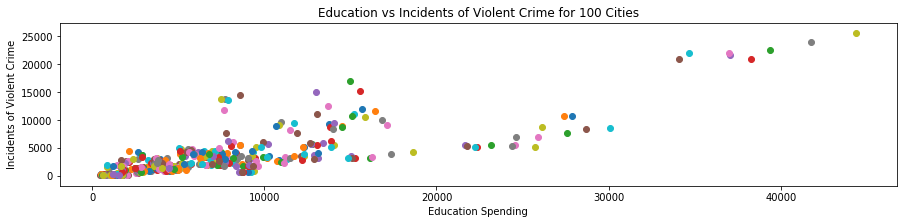

In [17]:
num_cities = 100
random_sample = merged_fbi_df[merged_fbi_df.city_name.isin(merged_fbi_df.city_name.sample(num_cities).values)][cols]
cols_metadata = ['city_name','city_population','year']
fisc_cols =['rev_total','education_services','education','educ_higher','educ_elem_sec','social_services','public_welfare','welfare_cash','welfare_vendors','welfare_other','correction','parks_recreation','housing_commdevt']
cols = cols_metadata + fisc_cols + ['property_crime','violent_crime']
random_sample = random_sample[cols].drop_duplicates()


for i in fisc_cols:
    random_sample[i] = random_sample[i] * random_sample['city_population'] / 10**5
    
    
fig, ax = plt.subplots(figsize=(15, 3))
for i in random_sample['year'].unique():
    for j in random_sample['city_name'].unique():
        by_year = random_sample[random_sample.year==i]
        by_city = by_year[by_year.city_name==j]
        ax.scatter(by_city['education_services'], by_city['violent_crime'],label=str(i)+' '+str(j))

plt.title("Education vs Incidents of Violent Crime for "+str(num_cities)+' Cities')
plt.xlabel('Education Spending')
plt.ylabel('Incidents of Violent Crime')

In [29]:
merged_fbi_df.sort_values(by='population', ascending=False)[['city_name','population','main_city']]

,city_name,population,main_city
215,"Houston, TX",2338235,Houston
214,"Houston, TX",2334348,Houston
207,"Houston, TX",2280859,Houston
213,"Houston, TX",2275221,Houston
212,"Houston, TX",2219933,Houston
211,"Houston, TX",2180606,Houston
210,"Houston, TX",2177273,Houston
209,"Houston, TX",2143628,Houston
208,"Houston, TX",2143628,Houston
153,"San Antonio, TX",1520712,San Antonio


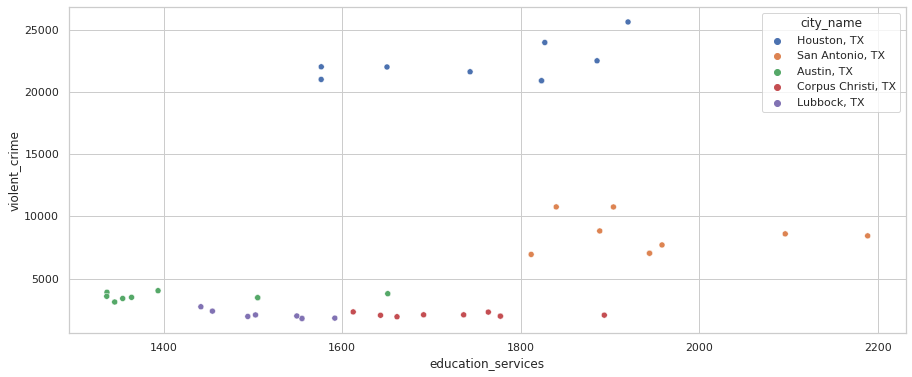

In [52]:
texas = merged_fbi_df[merged_fbi_df['city_name'].str.contains('TX')].sort_values(by='population', ascending=False)
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.scatterplot(data=texas, x="education_services", y="violent_crime", hue="city_name")

#plt.legend()

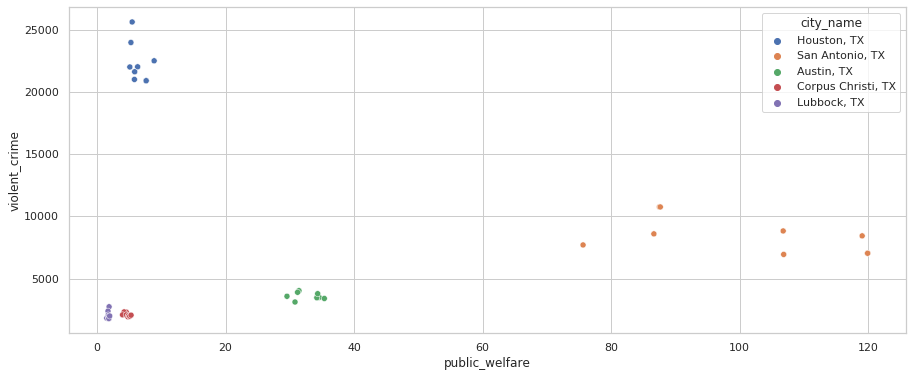

In [51]:
texas = merged_fbi_df[merged_fbi_df['city_name'].str.contains('TX')].sort_values(by='population', ascending=False)
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.scatterplot(data=texas, x="public_welfare", y="violent_crime", hue="city_name")
#plt.xlabel('Year')
#plt.xticks(rotation=90)
#plt.ylabel('Total CO2 Emissions (Kt)')
#_=plt.title("Top 5 Countries CO2 Emissions 1960-2014")


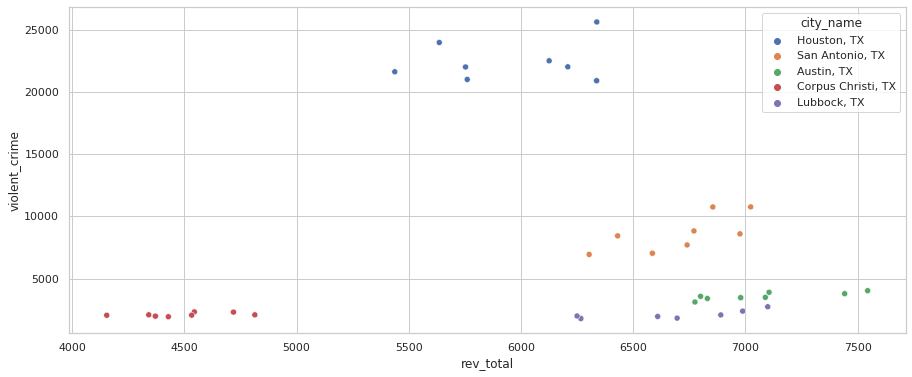

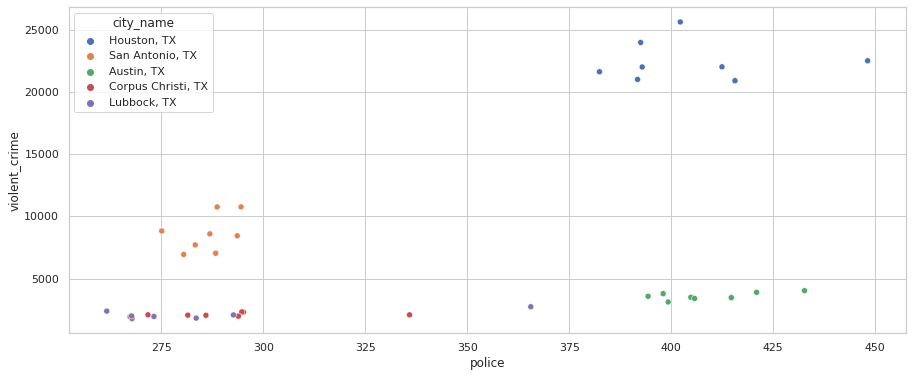

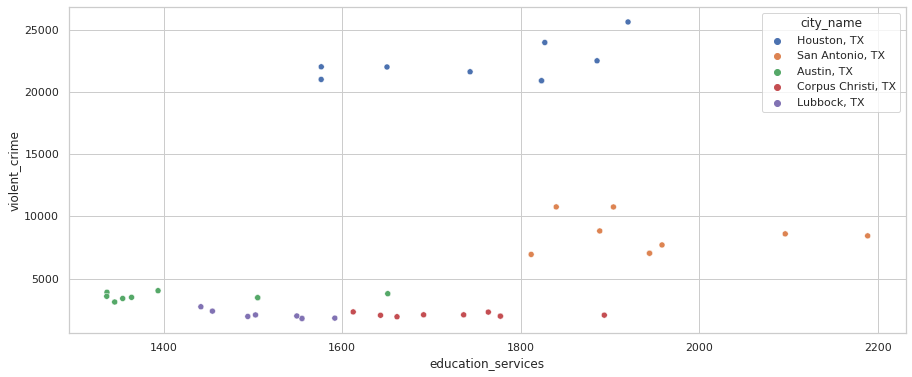

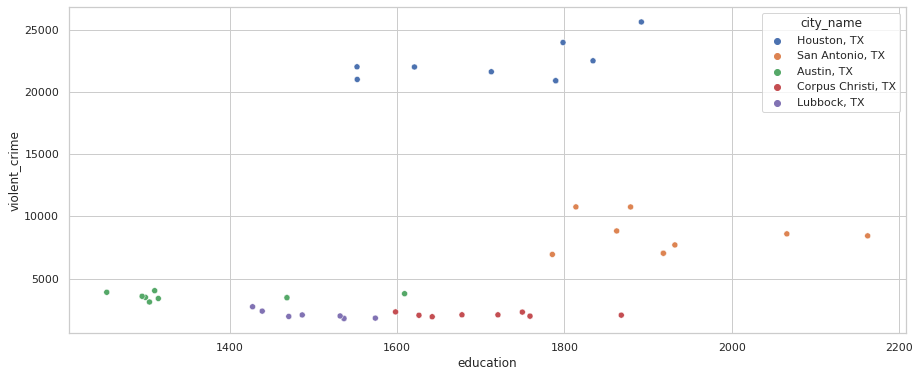

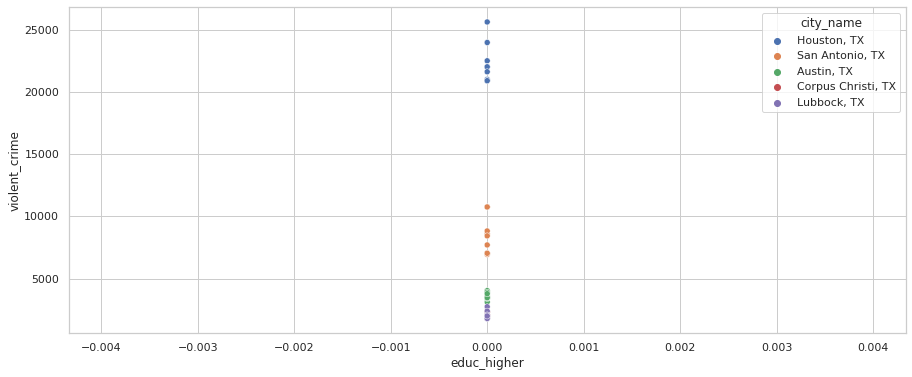

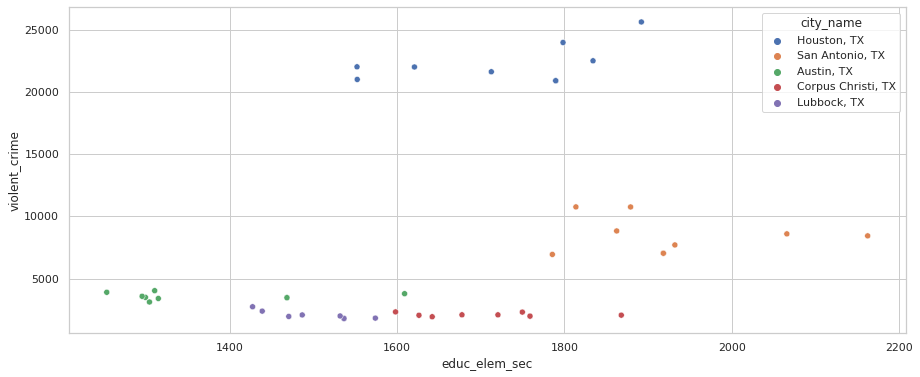

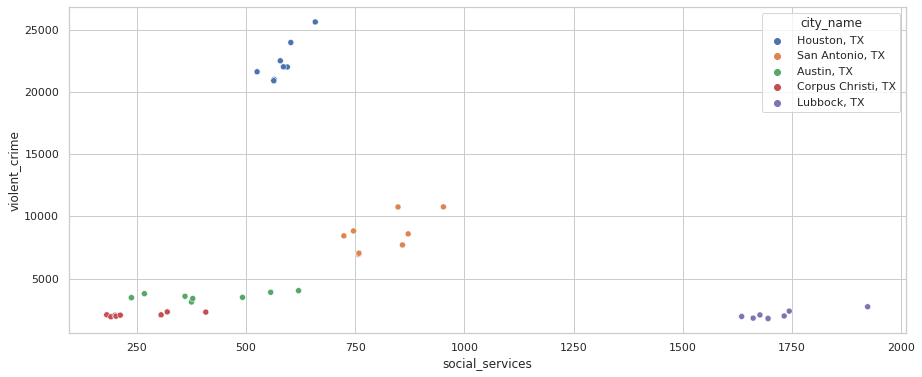

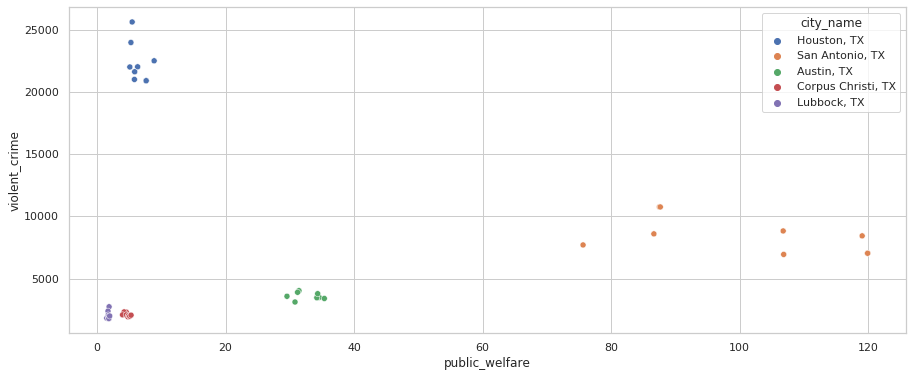

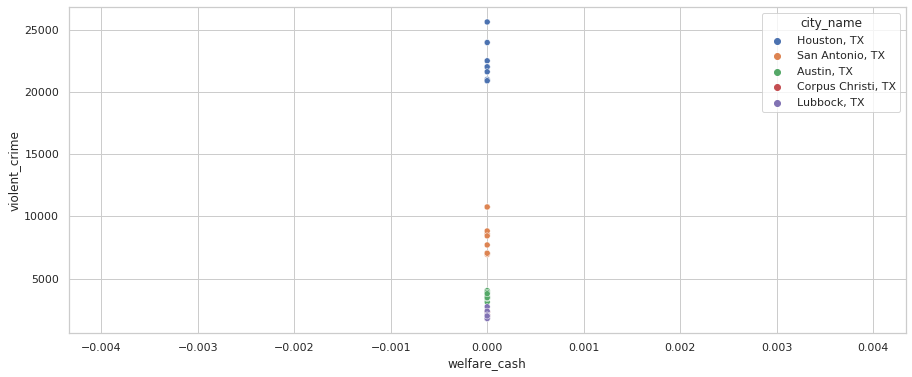

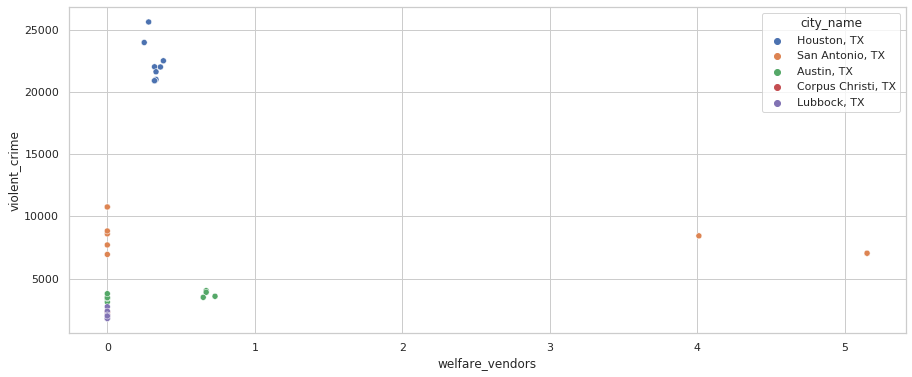

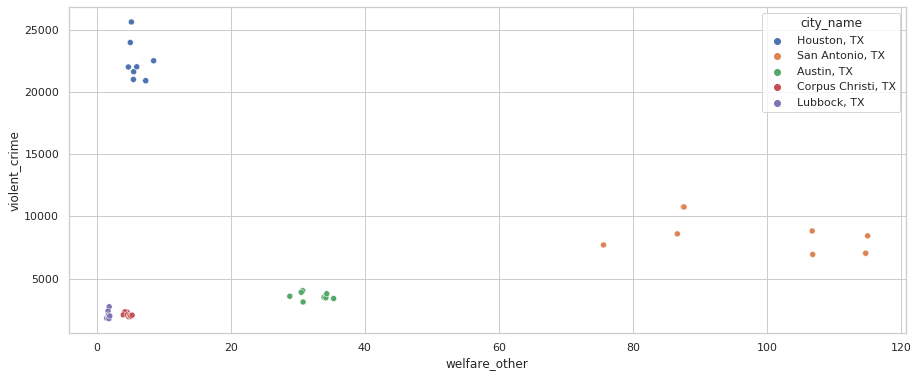

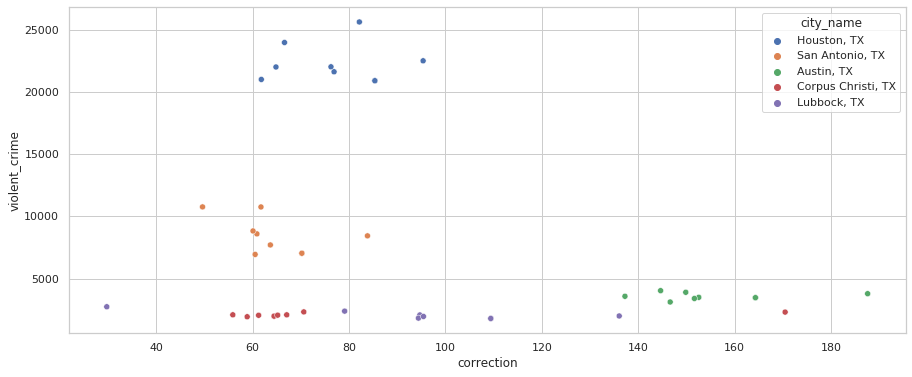

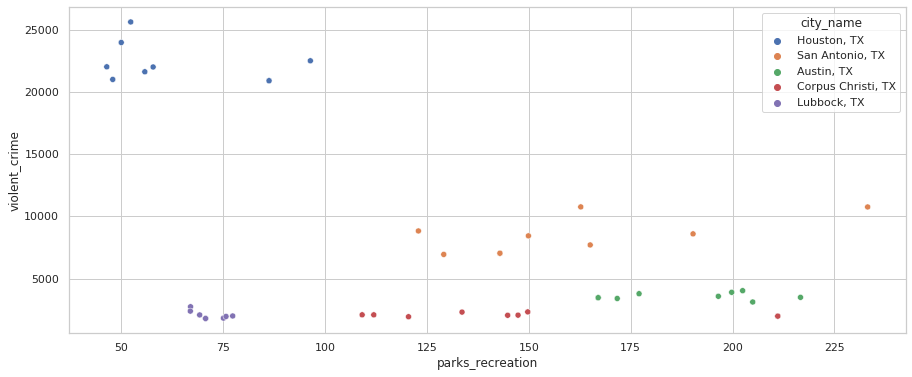

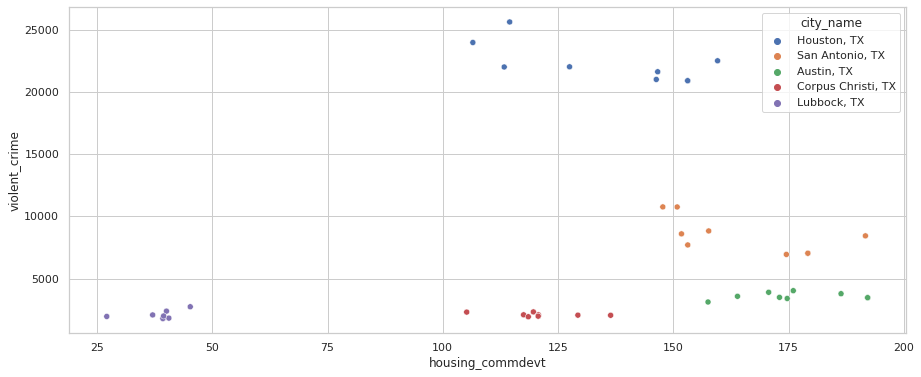

In [55]:
fisc_cols =['rev_total','police','education_services','education','educ_higher','educ_elem_sec','social_services','public_welfare','welfare_cash','welfare_vendors','welfare_other','correction','parks_recreation','housing_commdevt']
for i in fisc_cols:
    fig, ax = plt.subplots(figsize=(15, 6))
    g = sns.scatterplot(data=texas, x=i, y="violent_crime", hue="city_name")
    

In [75]:
merged_fbi_df[merged_fbi_df['city_name']=='Detroit, MI'][fisc_cols+['violent_crime','property_crime']].drop_duplicates()

,rev_total,police,education_services,education,educ_higher,educ_elem_sec,social_services,public_welfare,welfare_cash,welfare_vendors,welfare_other,correction,parks_recreation,housing_commdevt,violent_crime,property_crime
419,7184.37,557.96,2049.70,1970.29,0.0,1970.29,473.31,285.94,22.33,245.00,18.61,169.12,98.03,74.37,16976.0,47787.0
420,8934.09,604.24,2190.29,2115.29,0.0,2115.29,432.48,268.09,1.38,254.10,12.61,165.06,89.19,122.58,15245.0,43818.0
422,6813.12,582.07,1845.27,1792.24,0.0,1792.24,425.84,259.11,0.00,245.24,13.87,162.79,116.71,90.31,15011.0,40956.0
423,7860.67,738.63,1229.14,1171.78,0.0,1171.78,354.67,263.30,0.00,251.49,11.80,171.04,133.29,236.38,14504.0,40835.0
424,7631.80,455.24,1142.53,1089.95,0.0,1089.95,383.59,263.63,0.00,257.14,6.49,174.87,152.42,217.23,13616.0,32983.0
425,7152.38,432.20,1120.26,1083.38,0.0,1083.38,340.47,241.96,0.00,239.32,2.64,137.73,265.44,224.32,11846.0,27559.0
426,6325.58,420.24,1132.59,1078.29,0.0,1078.29,363.69,282.71,0.00,280.09,2.62,136.57,362.18,177.16,13705.0,31630.0
427,6862.48,420.89,1106.59,1059.69,0.0,1059.69,386.84,282.13,0.00,278.13,4.00,124.45,876.39,176.00,13796.0,30458.0


In [77]:
pc = merged_fbi_df[merged_fbi_df['city_name']=='Detroit, MI'][fisc_cols+['violent_crime','property_crime']].drop_duplicates().pct_change()
pc = pc.fillna(0)

In [78]:
pc['year'] = merged_fbi_df[merged_fbi_df['city_name']=='Detroit, MI']['year']

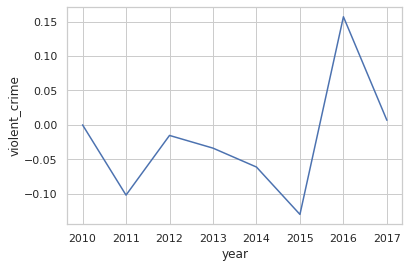

In [79]:
sns.lineplot(data=pc, x="year", y="violent_crime")

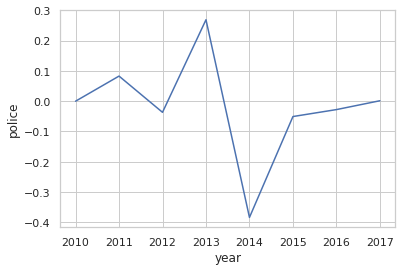

In [80]:
sns.lineplot(data=pc, x="year", y="police")

In [109]:
total_country_proxy = merged_fbi_df[['city_name','population']+fisc_cols+['year','violent_crime','property_crime']]
for i in fisc_cols:
    total_country_proxy[i] = total_country_proxy[i] * total_country_proxy['population']

    
total_country_proxy = total_country_proxy.drop_duplicates().groupby('year').sum().reset_index()
#
#total_country_proxy

/home/musaup/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


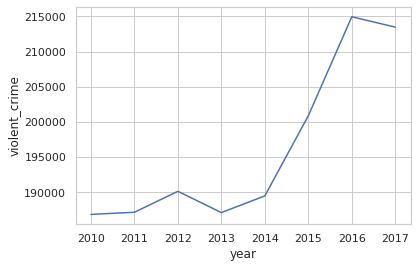

In [110]:

sns.lineplot(data=total_country_proxy,x='year',y='violent_crime')
_= ax.set_xlabel("Year")
_=ax.set_ylabel("Average Total Gas Emissions (kT)") 
_=plt.title("Average Gas Emissions Per Year 1960-2010")

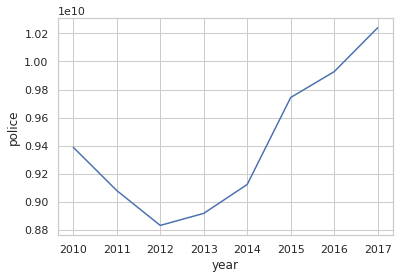

In [111]:
sns.lineplot(data=total_country_proxy,x='year',y='police')

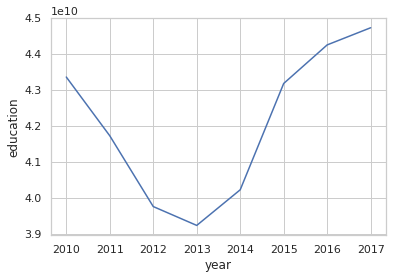

In [112]:
sns.lineplot(data=total_country_proxy,x='year',y='education')

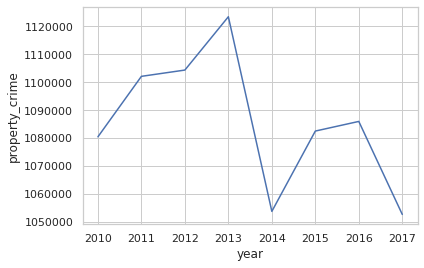

In [113]:
sns.lineplot(data=total_country_proxy,x='year',y='property_crime')